In [1]:
#For Downloading the dataset on colab

#!wget https://datasets.aicrowd.com/default/aicrowd-public-datasets/food-recognition-challenge/v0.4/test_images-v0.4.tar.gz
#!wget https://datasets.aicrowd.com/default/aicrowd-public-datasets/food-recognition-challenge/v0.4/train-v0.4.tar.gz

In [2]:
#!unzip train-v0.4.tar.gz

In [3]:
#Extract dataset from the tar files
#!for f in *.tar.gz; do tar xf "$f"; done

In [4]:
#%pip install git+https://github.com/tensorflow/examples

In [5]:
#%pip install git+https://github.com/AIcrowd/coco.git#subdirectory=PythonAPI

In [6]:
import tensorflow as tf
from keras import backend as K
from tensorflow_examples.models.pix2pix import pix2pix

#from google.colab import drive

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np

from pycocotools import mask as cocomask

import os

#drive.mount('/content/drive')

**Loading the data**

In [7]:
from pycocotools.coco import COCO

#Loading the coco annotations
folder_loc = "/home/belericks7/Documenti/deep_learning"

coco_train = COCO(folder_loc + '/train/annotations.json')
coco_val = COCO(folder_loc + '/val/annotations.json')


loading annotations into memory...
Done (t=1.43s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


**Exploring the data**

In [8]:
def plot_image(image_id):
    #read the image
    img = coco_train.loadImgs(image_id)[0]
    image = mpimg.imread(folder_loc + '/train/images/' + img['file_name'])
    
    #display image
    img_plot = plt.imshow(image)
    
    #loading image id
    annotations = coco_train.loadAnns(coco_train.getAnnIds(imgIds=image_id))

    for i in range(len(annotations)):
        #different color for different annotations
        colors = ['b', 'c', 'r', 'g', 'm', 'y', 'k'][i]
        ann = annotations[i]

        #plotting segmentation
        for seg in ann['segmentation']:
            plt.fill(seg[0::2], seg[1::2], colors, alpha=0.4)
            plt.fill(seg[0::2], seg[1::2], colors, alpha=0.8)
  
    #show results
    plt.show()

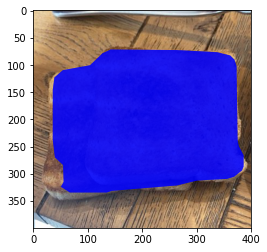

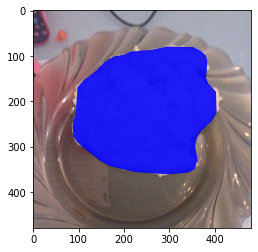

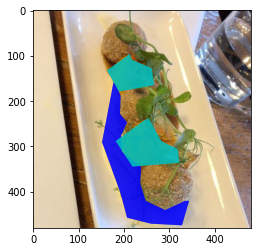

In [9]:
#Plotting a few random images

np.random.seed(100)
img_num = []
rand = np.random.randint(0, len(coco_train.getImgIds()), 3)
for i in rand:
    img_num.append(coco_train.getImgIds()[i])
for ids in img_num:
    plot_image(ids)

**Loading and cleaning the data**

In [10]:
# display COCO categories
categories = coco_train.loadCats(coco_train.getCatIds())
names=[cat['name'] for cat in categories]
print('COCO categories: ', len(names))

COCO categories:  273


Sorting the category ids by popularity

In [11]:
catIds_raw = coco_train.getCatIds()
catIds = []
for cat in catIds_raw:
  catIds.append([len(coco_train.getImgIds(catIds=cat)), cat])

catIds.sort()
cat_ids = [cat_num[1] for cat_num in catIds ]

In [12]:
train_data_not_saved = not (os.path.exists(folder_loc + 'y_train.npy'))
val_data_not_saved = not (os.path.exists(folder_loc + 'y_val.npy'))

#size that image are resize to
image_size = 256

#number of classes / images
num_classes = len(catIds_raw) + 1
num_images_train = len(coco_train.getImgIds())
num_images_val = len(coco_val.getImgIds())

Preparing the training set

In [ ]:
#Run only if data needs to be saved
if train_data_not_saved:
  
  #Creating blank X and blank Y
  X_train = np.zeros((num_images_train, image_size, image_size, 3))
  Y_train = np.zeros((num_images_train, image_size, image_size, 1))

  #iterating through train images
  for i in range(num_images_train):

    #printing how far in the iteration
    print(str(i+1) + '/' + str(num_images_train))

    #current image
    image = coco_train.getImgIds()[i]
    #load annotations
    annotations = coco_train.loadAnns(coco_train.getAnnIds(imgIds=image))
    #creating a matrix of zeros to store annotations
    mask = np.zeros((coco_train.imgs[image]['height'], coco_train.imgs[image]['width'], 1))

    for ann in annotations:

      #determining class by index in the cat_ids list
      ann_class = cat_ids.index(ann['category_id']) + 1
      #filling zeros matrix with appropriate class
      #when there is multiclass overlap more common class wins since we sorted above
      mask[:, :, 0] = np.maximum(mask[:, :, 0], coco_train.annToMask(ann) * ann_class)
    
    #resizing image
    mask = tf.image.resize(mask, (image_size, image_size))
    Y_train[i] = mask

  #Saving results
  np.save(arr=Y_train, file=folder_loc + 'y_train')

Preparing the validation set

In [13]:
#Run only if data needs to be saved
if val_data_not_saved:

  #Creating blank X and blank Y
  X_val = np.zeros((num_images_val, image_size, image_size, 3))
  Y_val = np.zeros((num_images_val, image_size, image_size, 1))


  #iterating through train images
  for i in range(num_images_val):
    
    #print(str(i+1) + '/' + str(num_images_train))

    #current image
    image = coco_val.getImgIds()[i]
    #load annotations
    annotations = coco_val.loadAnns(coco_val.getAnnIds(imgIds=image))
    #creating a matrix of zeros to store annotations
    mask = np.zeros((coco_val.imgs[image]['height'], coco_val.imgs[image]['width'], 1))

    for ann in annotations:

      #determining class by index in the cat_ids list
      ann_class = cat_ids.index(ann['category_id']) + 1
      #filling zeros matrix with appropriate class
      #when there is multiclass overlap more common class wins since we sorted above
      mask[:, :, 0] = np.maximum(mask[:, :, 0], coco_val.annToMask(ann) * ann_class)
    
    #resizing image
    mask = tf.image.resize(mask, (image_size, image_size))
    Y_val[i] = mask
  
  #Saving results
  np.save(arr=Y_val, file=folder_loc + 'y_val')